In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data Import

In [31]:
data_iris=datasets.load_iris()

In [32]:
df_iris_X=pd.DataFrame(data_iris['data'],columns=data_iris['feature_names'])
df_iris_Y=pd.DataFrame(data_iris['target'],columns=['target'])


In [33]:
conditions=[df_iris_Y['target']==0,
           df_iris_Y['target']==1,
           df_iris_Y['target']==2]
choices=['setosa','versicolor','virginica']
df_iris_Y['target_name']=np.select(conditions,choices,default=np.NaN)

# Data Visualisation

In [34]:
df_iris=pd.concat([df_iris_X,df_iris_Y],axis=1)
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


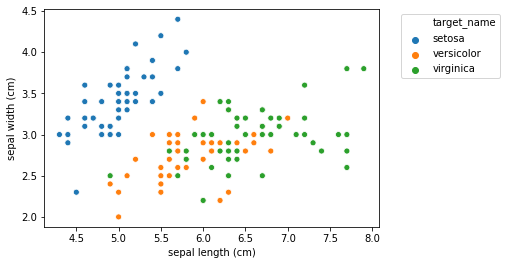

In [37]:
sns.scatterplot(x='sepal length (cm)',y='sepal width (cm)',hue='target_name',data=df_iris)
plt.legend(bbox_to_anchor=[1.05,1],loc=2)

# K nearest neighbours SK learn implementation

In [201]:
# split into train and test
X_train, X_test, y_train, y_test=train_test_split(df_iris_X, df_iris_Y['target'], test_size=0.33, random_state=0)

In [202]:
# scale
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [203]:
# initialise and fit model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=3)

In [204]:
# get predictions
predictions=knn_model.predict(X_test_scaled)

# check predictions vs ground truth
print(confusion_matrix(y_true=y_test,y_pred=predictions))

print(classification_report(y_true=y_test,y_pred=predictions))


[[16  0  0]
 [ 0 18  1]
 [ 0  1 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.95      0.95      0.95        19
           2       0.93      0.93      0.93        15

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



# Manual implementation with euclidean distance

In [205]:
# calculate the distance between the test point and all other points
# find the closest K points
# decide the class by voting
# if tied, select the class of the closest point

In [206]:
def get_closest_class(test_data_point,k):
    distances={}

    # getting the distance for each data point
    for train_index in range(0,X_train_scaled.shape[0]):
        train_data_point=X_train_scaled[train_index]

        num_features=test_data_point.shape[0]

        squares=0

        # calculating the minkowski distance
        for i in range(0,num_features):
            square=(test_data_point[i]-train_data_point[i])**2
            squares=squares+square

        distance=squares**(1/num_features)

        distances[train_index]={
            'distance':distance,
            'target':y_train.iloc[train_index]
        }

    # put the distances and labels in a dataframe
    df_distances=pd.DataFrame.from_dict(distances,orient='index')

    df_distances['rank']=df_distances['distance'].rank(ascending=True)

    df_closes_points=df_distances[df_distances['rank']<=k]



    # find number of points of each class
    df_count=pd.DataFrame(columns=['Count'])

    for class_index in range(0,num_classes):

        num_of_class=df_closes_points[df_closes_points['target']==class_index].shape[0]
        df_count.at[class_index,'Count']=num_of_class

    # If there's one clear majority winner
    if df_count[df_count['Count']==df_count['Count'].max()].shape[0]==1:
        closest_class=df_count.index[df_count['Count']==df_count['Count'].max()].tolist()[0]

    # If there are multiple winners
    else:
        closest_class=df_closes_points.iloc[0]['target']

    return closest_class


In [207]:
def manual_knn_predict(X_test_scaled,k=3):
    
    predictions=[]
    for i in range(0,X_test_scaled.shape[0]):
        test_data_point=X_test_scaled[i]
        prediction=get_closest_class(test_data_point,k=k)
        predictions.append(prediction)
    
    return predictions
    

In [209]:
# get predictions
knn_manual_predictions=manual_knn_predict(X_test_scaled,k=3)

# check predictions vs ground truth
print(confusion_matrix(y_true=y_test,
                       y_pred=knn_manual_predictions))

print(classification_report(y_true=y_test,
                            y_pred=knn_manual_predictions))


[[16  0  0]
 [ 0 18  1]
 [ 0  1 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.95      0.95      0.95        19
           2       0.93      0.93      0.93        15

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



> for k=3 gives the same classification result as sklearn implementation